In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
# pd.set_option('display.max_columns', None)

In [2]:
dataPath = "HW3_Data/ecs171.dataset.txt"

In [3]:
data = pd.read_table(dataPath)

In [4]:
data.shape

(194, 4501)

In [5]:
data.head()

,ID,Strain,Medium,Stress,GenePerturbed,GrowthRate,b3356,b2922,b2519,b3823,...,b4673,b4684,b4689,b4685,b4683,b4682,b4699,b4698,b4704,b4703
0,T8129,MG1655,MD001,none,oxyR_KO,0.637,0.304790,0.506615,0.289473,0.289473,...,0,0,0,0,0,0,0,0,0,0
1,T8130,MG1655,MD001,none,oxyR_KO,0.637,0.361095,0.582885,0.259295,0.259295,...,0,0,0,0,0,0,0,0,0,0
2,T8131,MG1655,MD001,none,oxyR_KO,0.637,0.295920,0.477482,0.304459,0.304459,...,0,0,0,0,0,0,0,0,0,0
3,T8135,MG1655,MD001,none,soxS_KO,0.724,0.332041,0.554672,0.308533,0.308533,...,0,0,0,0,0,0,0,0,0,0
4,T8136,MG1655,MD001,none,soxS_KO,0.724,0.323373,0.442617,0.318442,0.318442,...,0,0,0,0,0,0,0,0,0,0


#### Question 1: Create a predictor of the bacterial growth attribute by using only the expression of the genes as attributes. Not all genes are informative for this task, so use a regularized regressiontechnique (lasso, elastic net, ridge) and explain what it does (we have not covered the specifics of each method, so you have to do some reading). Which one is the optimal constrained parameter value (usually denoted by λ)? Report the number of features that have non-zero coefficients and the 10-fold cross-validation generalization error of the technique

In [6]:
# Lambda values to try
_lambda = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
_lasso = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

In [7]:
y = data["GrowthRate"].values
X = data.iloc[:, 6:].values

In [8]:
print(y.shape)
print(X.shape)

(194,)
(194, 4495)


#### Ridge regression

In [9]:
def ridge(X, y, _lambda):
    scores = {}
    nonzeroFeatures = []
    # Split the data in K = 10 folds
    kf = KFold(n_splits=10)
    indexes = list(kf.split(X))
    optimizedLambdaError = 9999
    optimizedLambda = 0
    clf = Ridge(normalize=True, solver='sag')
    # clf = Lasso()
    for lam in _lambda:
        score = 0
        nonzero = 0
        errors = []
        clf.set_params(alpha=lam)
        for train, test in indexes:
            Xtrain = X[train]
            ytrain = y[train]
            Xtest = X[test]
            ytest = y[test]
            # Train
            clf.fit(Xtrain, ytrain)
            # Test
            y_predict = clf.predict(Xtest)
            error = ((ytest - y_predict)**2).sum()
            nonzero += np.count_nonzero(clf.coef_)
            # weights = clf.coef_
            # cols = X.loc[:, z].columns.values.tolist()
            # print("Number of non-zero features: " + str(len(nonzero)) + ", alpha: " + str(lam))
            score += np.sum(error)
            # errors.append(np.sum(error))
        nonzeroFeatures.append(nonzero/10)
        scores[lam] = score/10
        if(scores[lam] < optimizedLambdaError):
            optimizedLambdaError = scores[lam]
            optimizedLambda = lam
    
    ax = plt.gca()
    ax.plot(_lambda, nonzeroFeatures)
    # ax.set_xscale('log')
    # ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel('alpha')
    plt.ylabel('Number of nonzero features')
    plt.title('Number of nonzero features vs alpha ')
    plt.axis('tight')
    plt.show()
    return scores, optimizedLambda

def non_zero_coeff(X, y, _lambda):
    clf = Ridge(normalize=True, solver='sag')
    clf.set_params(alpha=_lambda)
    clf.fit(X, y)
    nonzero = np.count_nonzero(clf.coef_)
    print("Number of non-zero features: " + str(nonzero) + ", alpha: " + str(_lambda))
    return nonzero

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


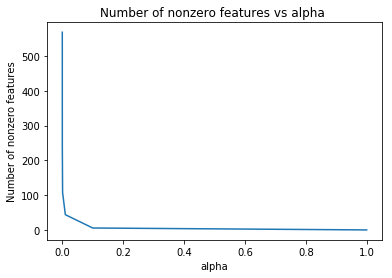

In [102]:
gen_cross_validation_error, optimizedLambda = ridge(X, y, _lasso)

#### Generalized cross-validation error

In [10]:
gen_cross_validation_error

NameError: name 'gen_cross_validation_error' is not defined

In [98]:
optimizedLambda

0.8

#### The optimal constraint parameter is 0.9. Find the number of features with non-zero coefficients using lambda = 0.9

In [99]:
non_zero_coeff(X, y, 0.9)

Number of non-zero features: 4434, alpha: 0.9


4434

#### Note:
Ridge regression doesn't remove features as the lambda increases. But Lasso on the other hand reduces the number of features used.

####  Question 2: Extend your predictor to report the confidence interval of the prediction by using the bootstrapping method. Clearly state the methodology and your assumptions.

In [31]:
def bootstrap():
    dataPath = "HW3_Data/ecs171.dataset.txt"
    data = pd.read_csv(dataPath, header=None)
    values = data.values
    # configure bootstrap
    n_iterations = 1000
    n_size = int(len(data) * 0.50)
    # run bootstrap
    stats = list()
    for i in range(2):
        # prepare train and test sets
        train = resample(values, n_samples=1)
        print(train[0])
        
        # test = np.array([x for x in values if x.tolist() not in train.tolist()])
        # fit model
        # model = Ridge(normalize=True, solver='sag', alpha=0.9)
        # model.fit(train[:,6:], train[:,5])
        # evaluate model
        # predictions = model.predict(test[:,6:])
        # score = accuracy_score(test[:,5], predictions)
        # print(score)
        # stats.append(score)
    # plot scores
    # pyplot.hist(stats)
    # pyplot.show()
    # confidence intervals
    # alpha = 0.95
    # p = ((1.0-alpha)/2.0) * 100
    # lower = max(0.0, numpy.percentile(stats, p))
    # p = (alpha+((1.0-alpha)/2.0)) * 100
    # upper = min(1.0, numpy.percentile(stats, p))
    # print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))